In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os

def plot_images(img_list):
    for img in img_list:
        plt.figure(figsize=(10,10))
        plt.imshow(img, 'gray')
        plt.show()

def print_info(data):
    print('Shape: {}'.format(data.shape))
    print('dtype: {}'.format(data.dtype))
    print('Min: {}'.format(data.min()))    
    print('Min: {}'.format(data.max()))    
    print('Mean: {}'.format(data.mean()))    

In [2]:
train_path = './data_example/train'
test_path = './data_example/test'
drawn_test_path = './data_example/drawn_test'

train_filenames = sorted([os.path.join(filename) for filename in os.listdir(train_path)])
test_filenames = sorted([os.path.join(filename) for filename in os.listdir(test_path)])
drawn_test_filenames = sorted([os.path.join(filename) for filename in os.listdir(drawn_test_path)])

# See one image

2023-04-01 11:19:41.055524: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


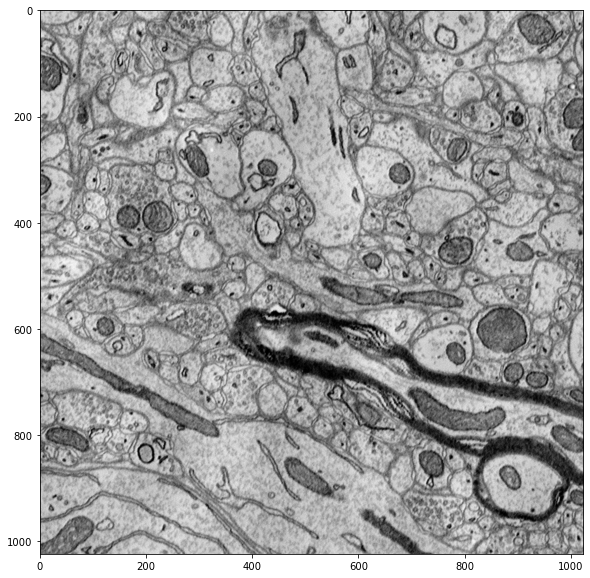

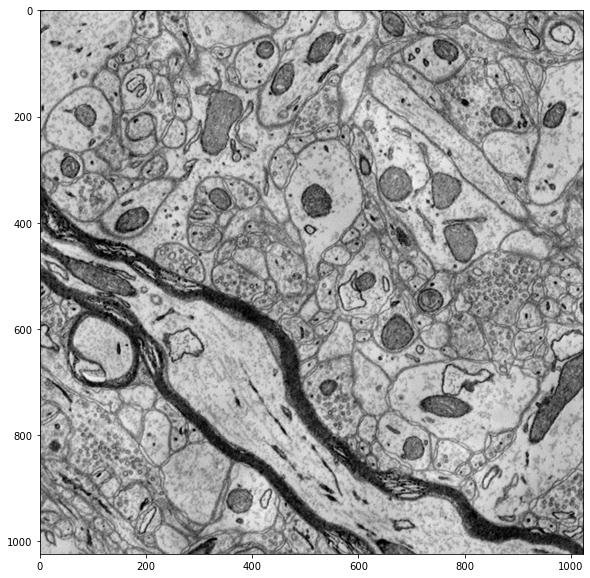

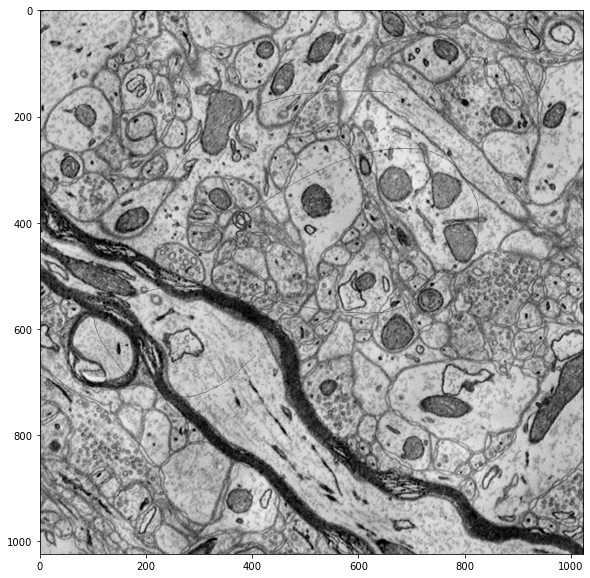

Shape: (1024, 1024)
dtype: float32
Min: 0.0
Min: 1.0
Mean: 0.583771824836731


In [3]:
from src.datasets import read_image
hr_img = read_image(os.path.join(train_path, train_filenames[0]))
lr_img = read_image(os.path.join(test_path, test_filenames[0]))
drawn_lr_img = read_image(os.path.join(drawn_test_path, drawn_test_filenames[0]))

plot_images([hr_img, lr_img, drawn_lr_img ])
print_info(drawn_lr_img)

# Test `prepare_data`

X_train
Shape: (400, 128, 128, 1)
dtype: float32
Min: 0.0
Min: 1.0
Mean: 0.5956820249557495


Y_train
Shape: (400, 512, 512, 1)
dtype: float32
Min: 0.0
Min: 1.0
Mean: 0.5426756143569946


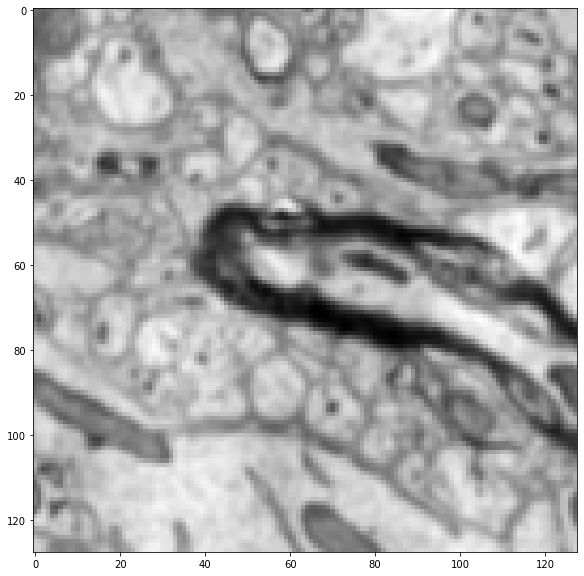

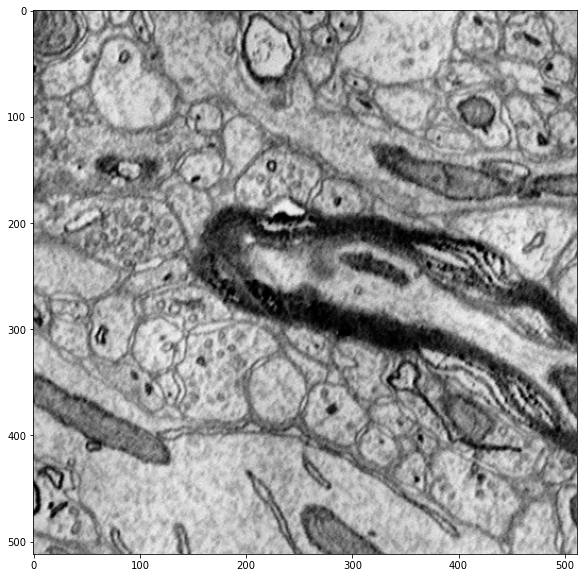

In [4]:
from src.datasets import extract_random_patches_from_folder

train_patches_wf, train_patches_gt = extract_random_patches_from_folder(
                                        hr_data_path=train_path, 
                                        lr_data_path=None, 
                                        filenames=train_filenames, 
                                        scale_factor=4, 
                                        crappifier_name='em_crappify', 
                                        lr_patch_shape=(128, 128), 
                                        num_patches=4)

X_train = np.expand_dims(train_patches_wf, axis=-1)
Y_train = np.expand_dims(train_patches_gt, axis=-1)

print('X_train')
print_info(X_train)
print('\n')

print('Y_train')
print_info(Y_train)

plot_images([X_train[0], Y_train[0]])

(262144,)
(262144,)


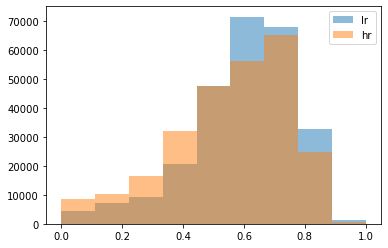

In [5]:
bins = np.linspace(-0, 1, 10)

print(np.repeat(X_train[0,:,:,0].flatten(), 16).shape)
print(Y_train[0,:,:,0].flatten().shape)

plt.hist(np.repeat(X_train[0,:,:,0].flatten(), 16), bins, alpha=0.5, label='lr')
plt.hist(Y_train[0,:,:,0].flatten(), bins, alpha=0.5, label='hr')
plt.legend(loc='upper right')
plt.show()

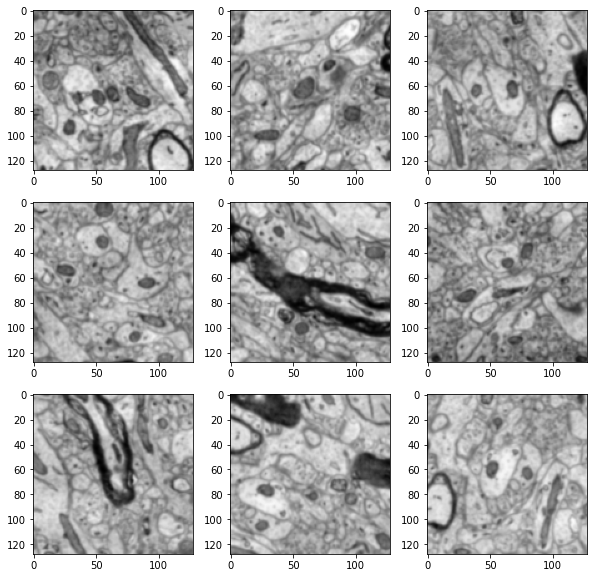

In [22]:
from src.datasets import get_generator 
batch_size = 4
train_generator = get_generator(X_data=X_train,
                                Y_data=Y_train,
                                batch_size=batch_size,
                                show_examples=True,
                                rotation=True,
                                horizontal_flip=True,
                                vertical_flip=True)

In [23]:
for lr,hr in train_generator:
    print('LR')
    print_info(lr)
    print('\n')
    print('HR')
    print_info(hr)
    break

LR
Shape: (4, 128, 128, 1)
dtype: float32
Min: 0.0
Min: 1.0
Mean: 0.5826003551483154


HR
Shape: (4, 512, 512, 1)
dtype: float32
Min: 0.0
Min: 0.9958677887916565
Mean: 0.523485541343689


# Create a simple network (DFCAN for example)

In [24]:
library_name = 'tensorflow'

optimizer = 'Adam'

model_configuration = {'optim': {'early_stop':{'loss':'val_ssim_loss','mode':'max', 'patience':10},
                                 'adam':{'beta1':0.5,'beta2':0.9,'epsilon':1e-07},
                                 'adamax':{'beta1':0.5,'beta2':0.9,'epsilon':1e-07},
                                 'adamW':{'decay':0.004,'beta1':0.5,'beta2':0.9,'epsilon':1e-07},
                                 'sgd_momentum':0.9,
                                 'ReduceOnPlateau':{'monitor':'val_loss','factor':0.5,'patience':3},
                                 'MultiStepScheduler':{'lr_steps':[50000, 100000, 200000, 300000],
                                                       'lr_rate_decay':0.5}},
                       'rcan': {'num_filters':16,
                                'percp_coef': 1000},
                       'dfcan': {'n_ResGroup': 4, 'n_RCAB': 4},
                       'wdsr': {'num_res_blocks': 32},
                       'unet': {'init_channels': 16,
                                'depth': 4,
                                'upsample_method': 'SubpixelConv2D',
                                'maxpooling': False,
                                'percp_coef': 10},
                       'wgan': {'g_layers': 15,
                                'd_layers': 5,
                                'recloss': 100.0,
                                'lambda_gp':10},
                       'esrganplus': {'n_critic_steps':5},
                       'others': {'positional_encoding':False,
                                  'positional_encoding_channels':64}
                      }

from src.optimizer_scheduler_utils import select_optimizer, select_optimizer
optim = select_optimizer(library_name=library_name, optimizer_name=optimizer, 
                                learning_rate=0.001, check_point=None,
                                parameters=None, additional_configuration=model_configuration)
    
from src.model_utils import select_model
model = select_model(model_name='dfcan', input_shape=X_train.shape, output_channels=Y_train.shape, 
                        scale_factor=4, model_configuration=model_configuration)

loss_funct = 'mean_absolute_error'
eval_metric = 'mean_squared_error'

model.compile(optimizer=optim, loss=loss_funct, metrics=[eval_metric])

trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams

print('Trainable parameteres: {} \nNon trainable parameters: {} \nTotal parameters: {}'.format(trainableParams, 
                                                                                                        nonTrainableParams, 
                                                                                                    totalParams))

Trainable parameteres: 2373889 
Non trainable parameters: 0.0 
Total parameters: 2373889.0


In [25]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_167 (Conv2D)             (None, 128, 128, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
lambda_166 (Lambda)             (None, 128, 128, 64) 0           conv2d_167[0][0]                 
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 128, 128, 64) 36928       lambda_166[0][0]                 
____________________________________________________________________________________________

In [31]:

scheduler = 'OneCycle'

from src.optimizer_scheduler_utils import select_lr_schedule
lr_schedule = select_lr_schedule(library_name='tensorflow', lr_scheduler_name=scheduler, 
                                    data_len=X_train.shape[0]//batch_size, 
                                    number_of_epochs=1, learning_rate=0.001,
                                    monitor_loss=None, name=None, optimizer=None, frequency=None,
                                    additional_configuration=model_configuration)

import time
start = time.time()

history = model.fit(train_generator,
                    steps_per_epoch=np.ceil(X_train.shape[0]//batch_size),
                    epochs=1)

dt = time.time() - start
mins, sec = divmod(dt, 60) 
hour, mins = divmod(mins, 60) 
print("\nTime elapsed:",hour, "hour(s)",mins,"min(s)",round(sec),"sec(s)\n")


2023-04-01 15:53:22.530336: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-01 15:53:22.553015: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2295695000 Hz
2023-04-01 15:53:41.958404: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16777216 exceeds 10% of free system memory.
2023-04-01 15:53:42.024536: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16777216 exceeds 10% of free system memory.
2023-04-01 15:53:42.024536: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16777216 exceeds 10% of free system memory.
2023-04-01 15:53:42.035609: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16777216 exceeds 10% of free system memory.
2023-04-01 15:53:42.042857: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16777216 exceeds 10% of free system memory.


: 

: 